In [1]:
from Decoder import Decoder
from Encoder import Encoder
from VectorQuantizer import VectorQuantizer
from Residual import Residual 
from VQModel import VQModel

import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import savgol_filter
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm

import os
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.utils import make_grid

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Define the transformation pipeline
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
])

# Load your custom dataset
training_data = datasets.ImageFolder(root="data/images", transform=transform)
validation_data = datasets.ImageFolder(root="data/validation_images", transform=transform)

# Check the dataset size
print(f"Number of training samples: {len(training_data)}")

Number of training samples: 10000


In [3]:
batch_size = 10
num_training_updates = 2000

num_hiddens = 128
num_residual_hiddens = 32
num_residual_layers = 2

embedding_dim = 64
num_embeddings = 512

commitment_cost = 0.25
decay = 0.99
learning_rate = 1e-3

training_loader = DataLoader(training_data,
                             batch_size=batch_size,
                             shuffle=True,
                             pin_memory=True)

validation_loader = DataLoader(validation_data,
                               batch_size=1,
                               shuffle=True,
                               pin_memory=True)

In [4]:
model = VQModel(num_hiddens, num_residual_layers, num_residual_hiddens,
              num_embeddings, embedding_dim,
              commitment_cost, decay).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, amsgrad=False)

In [5]:
model.train()
train_res_recon_error = []
train_res_perplexity = []

for i in tqdm(range(num_training_updates)):
    (data, _) = next(iter(training_loader))
    data = data.to(device)
    optimizer.zero_grad()

    vq_loss, data_recon, perplexity = model(data)
    recon_error = F.mse_loss(data_recon, data) / 0.04
    loss = recon_error + vq_loss
    loss.backward()

    optimizer.step()

    train_res_recon_error.append(recon_error.item())
    train_res_perplexity.append(perplexity.item())

    if (i+1) % 100 == 0:
        torch.save(model.state_dict(), f"Models/Model_{i+1}")
        print('%d iterations' % (i+1))
        print('recon_error: %.3f' % np.mean(train_res_recon_error[-100:]))
        print('perplexity: %.3f' % np.mean(train_res_perplexity[-100:]))
        print()

  0%|          | 0/2000 [00:00<?, ?it/s]

100 iterations
recon_error: 1.236
perplexity: 1.767

200 iterations
recon_error: 0.074
perplexity: 1.773

300 iterations
recon_error: 0.054
perplexity: 1.843

400 iterations
recon_error: 0.140
perplexity: 1.909

500 iterations
recon_error: 0.054
perplexity: 1.976

600 iterations
recon_error: 0.034
perplexity: 2.209

700 iterations
recon_error: 0.025
perplexity: 2.472

800 iterations
recon_error: 0.019
perplexity: 2.534

900 iterations
recon_error: 0.015
perplexity: 2.568

1000 iterations
recon_error: 0.013
perplexity: 2.588

1100 iterations
recon_error: 0.012
perplexity: 2.595

1200 iterations
recon_error: 0.011
perplexity: 2.694

1300 iterations
recon_error: 0.010
perplexity: 2.794

1400 iterations
recon_error: 0.010
perplexity: 2.830

1500 iterations
recon_error: 0.009
perplexity: 2.819

1600 iterations
recon_error: 0.009
perplexity: 2.836

1700 iterations
recon_error: 0.008
perplexity: 2.848

1800 iterations
recon_error: 0.008
perplexity: 2.853

1900 iterations
recon_error: 0.008
pe

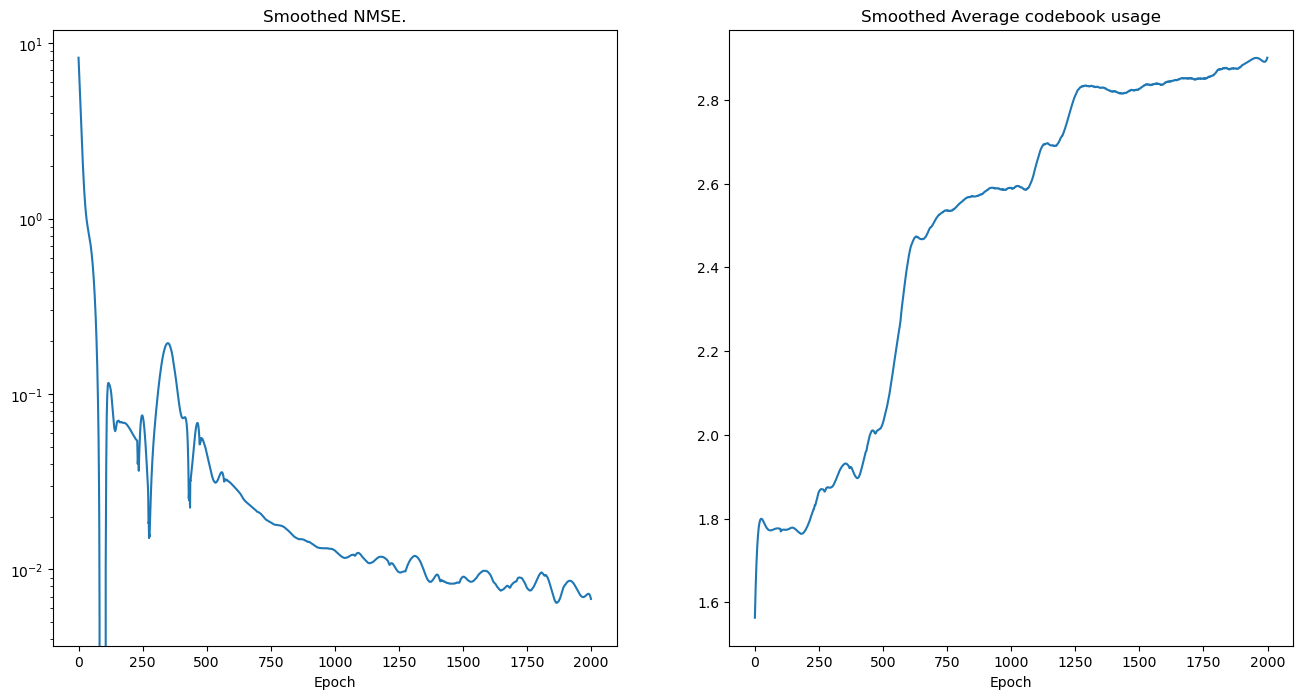

In [8]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('Epoch');

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage')
ax.set_xlabel('Epoch');

In [9]:
(valid_originals, _) = next(iter(validation_loader))
valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.21473682..1.2232301].


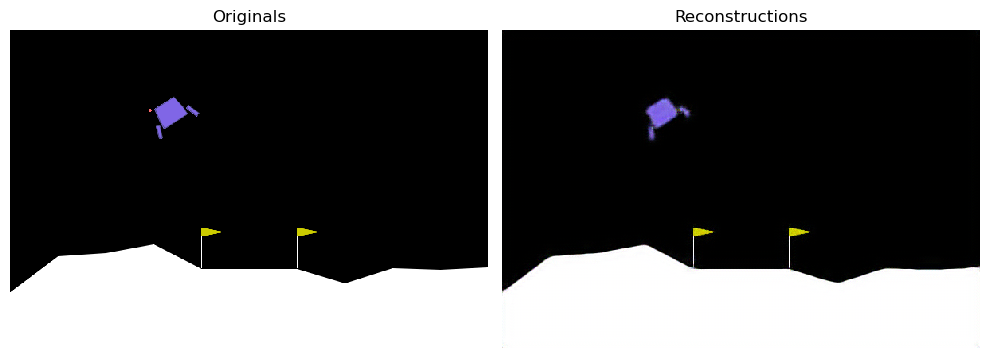

In [12]:
# Convert tensors to numpy arrays
npimg1 = (make_grid(valid_reconstructions.cpu().data) + 0.5).numpy();
npimg2 = (make_grid(valid_originals.cpu().data) + 0.5).numpy();

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[1].imshow(np.transpose(npimg1, (1, 2, 0)), interpolation='nearest')
axes[1].set_title("Reconstructions")
axes[1].axis('off')  # Turn off the axes

# Display the second image
axes[0].imshow(np.transpose(npimg2, (1, 2, 0)), interpolation='nearest')
axes[0].set_title("Originals")
axes[0].axis('off')

# Adjust layout and show
plt.tight_layout()
plt.show();